# Self-Drive Cars' Sentiment Analysis

- Implementing model based on previous notebook work

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

In [5]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('sentiment_self_drive.pkl')
df.shape

(6943, 2)

In [6]:
df.head()

,text,sent_numeric
0,Two places I'd invest all my money if I could:...,Beneficial
1,Awesome! Google driverless cars will help the ...,Beneficial
2,If Google maps can't keep up with road constru...,Risky
3,Autonomous cars seem way overhyped given the t...,Risky
4,Just saw Google self-driving car on I-34. It w...,Neutral


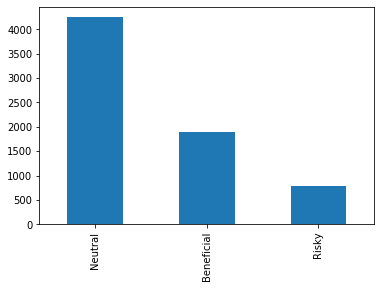

In [7]:
df.sent_numeric.value_counts().plot(kind='bar')

In [8]:
df.sent_numeric.value_counts()

Neutral       4245
Beneficial    1903
Risky          795
Name: sent_numeric, dtype: int64

In [9]:
df.sent_numeric.value_counts(normalize=True)

Neutral       0.611407
Beneficial    0.274089
Risky         0.114504
Name: sent_numeric, dtype: float64

## Label the categorical values

In [0]:
df['labels'] = df.sent_numeric.map({'Risky':0, 'Beneficial':1, 'Neutral':2})

In [11]:
df.head()

,text,sent_numeric,labels
0,Two places I'd invest all my money if I could:...,Beneficial,1
1,Awesome! Google driverless cars will help the ...,Beneficial,1
2,If Google maps can't keep up with road constru...,Risky,0
3,Autonomous cars seem way overhyped given the t...,Risky,0
4,Just saw Google self-driving car on I-34. It w...,Neutral,2


In [12]:
df.head()

,text,sent_numeric,labels
0,Two places I'd invest all my money if I could:...,Beneficial,1
1,Awesome! Google driverless cars will help the ...,Beneficial,1
2,If Google maps can't keep up with road constru...,Risky,0
3,Autonomous cars seem way overhyped given the t...,Risky,0
4,Just saw Google self-driving car on I-34. It w...,Neutral,2


In [0]:
df_label=df[['text','labels']]

In [0]:
#df_label.to_pickle('model_data.pkl')
#df_label.to_csv('model_data.csv',index=False)

In [15]:
# alternative way of seeing 
[print(df['sent_numeric'][i], df['labels'][i]) for i in range(0,5)]

Beneficial 1
Beneficial 1
Risky 0
Risky 0
Neutral 2


[None, None, None, None, None]

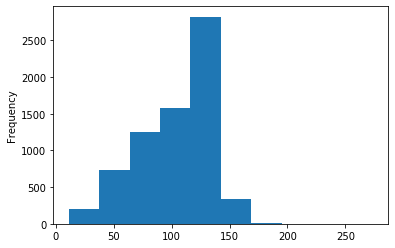

In [16]:
df['text'].str.len().plot.hist()

# 1)- Cleaning

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [0]:
df['cleaned']=[text_prepare(x) for x in df['text']]

In [19]:
print(df.text[:5])

0    Two places I'd invest all my money if I could:...
1    Awesome! Google driverless cars will help the ...
2    If Google maps can't keep up with road constru...
3    Autonomous cars seem way overhyped given the t...
4    Just saw Google self-driving car on I-34. It w...
Name: text, dtype: object


In [20]:
df.cleaned[:5]

0    two places id invest money could 3d printing s...
1    awesome google driverless cars help blind trav...
2    google maps cant keep road construction suppos...
3    autonomous cars seem way overhyped given techn...
4    saw google selfdriving car i34 painted green blue
Name: cleaned, dtype: object

In [21]:
df.cleaned[4]

'saw google selfdriving car i34 painted green blue'

### most common words

In [22]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('tco', 3702),
 ('car', 3600),
 ('cars', 3217),
 ('google', 2582),
 ('selfdriving', 2543),
 ('driverless', 1945),
 ('driving', 1712),
 ('self', 1462),
 ('googles', 620),
 ('autonomous', 385)]

# RNN

- Applying LSTM

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [24]:
df.head()

,text,sent_numeric,labels,cleaned
0,Two places I'd invest all my money if I could:...,Beneficial,1,two places id invest money could 3d printing s...
1,Awesome! Google driverless cars will help the ...,Beneficial,1,awesome google driverless cars help blind trav...
2,If Google maps can't keep up with road constru...,Risky,0,google maps cant keep road construction suppos...
3,Autonomous cars seem way overhyped given the t...,Risky,0,autonomous cars seem way overhyped given techn...
4,Just saw Google self-driving car on I-34. It w...,Neutral,2,saw google selfdriving car i34 painted green blue


In [0]:
Y=df['sent_numeric']

In [26]:
df['cleaned'].shape

(6943,)

In [0]:
X=df['cleaned']

In [28]:
print(X.shape)
print(Y.shape)

(6943,)
(6943,)


## Step1- Convert words to matrix

We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

### i-I started by fitting a tokenizer on my document as in here:

In [0]:
# Fitting
max_fatures = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 280
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)

In [30]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15398 unique tokens.


### ii- I wanted to check if my data is fitted correctly so I converted into sequence

In [0]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X)

In [32]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,153,944.0,190.0,945.0,328.0,20.0,428.0,946.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104,4.0,6.0,3.0,206.0,451.0,630.0,2294.0,69.0,1.0,4532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,139.0,27.0,329.0,32.0,1059.0,1060.0,201.0,6.0,2.0,18.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,3.0,781.0,44.0,2989.0,586.0,38.0,782.0,1182.0,783.0,781.0,81.0,2295.0,412.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,4.0,5.0,2.0,4533.0,4534.0,631.0,2990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It means that "two" is encoded as 153, "places" as 944 and so on...... "selfdriving" as 5 and finally "cars" as 3

In [33]:
df['cleaned'][0]

'two places id invest money could 3d printing selfdriving cars'

In [34]:
df['cleaned'][4]

'saw google selfdriving car i34 painted green blue'

**google is encoded as 4. And cars as 3 . car as 2. Let's confirm our encoding scheme with one more**

In [35]:
df['cleaned'][1]

'awesome google driverless cars help blind travel often https tco qwuxr0frbpv'

Perfect google is 4 and cars is 3

###  pad_sequence:To keep all vectors of same length, I will use pad_sequence

In [0]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [37]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (6943, 280)


To avoid AttributeError: 'numpy.ndarray' object has no attribute 'head', we will check in dataframe. Still input to neural network will be numpy array not dataframe

In [38]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,153,944,190,945,328,20,428,946,5,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,4,6,3,206,451,630,2294,69,1,4532
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,139,27,329,32,1059,1060,201,6,2,18,65
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,3,781,44,2989,586,38,782,1182,783,781,81,2295,412
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,5,2,4533,4534,631,2990


**All in one step**

In [0]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(X)
#X = tokenizer.texts_to_sequences(X)
#X = pad_sequences(X)

In [40]:
X_pd_sq.shape

(6943, 280)

## Step 2- Train-test split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq, Y, random_state=2019)

In [42]:
X_train.shape, X_test.shape

((5207, 280), (1736, 280))

In [43]:
print(y_train.shape)
print(y_test.shape)

(5207,)
(1736,)


## Step 3- Encoding y-labeled feature

In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [45]:
y_train[:5]

2915    Beneficial
3020       Neutral
2044       Neutral
2768    Beneficial
6586         Risky
Name: sent_numeric, dtype: object

In [46]:
y_train_ohe[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [47]:
y_test[:5]

5682       Neutral
6394       Neutral
2506         Risky
2165    Beneficial
1224    Beneficial
Name: sent_numeric, dtype: object

In [48]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [49]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Neutral', 'Beneficial', 'Risky']

In [50]:
len(unique_y_labels)

3

**Hence , our last dense layer will be of size 3**

## Step 4- Build LSTM model

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
# for our padding seq
input_length=X_pd_sq.shape[1]
uniq_y_label=len(unique_y_labels)


In [52]:
X_pd_sq.shape[1]

280

In [53]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [54]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 100)          500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 280, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 580,703
Trainable params: 580,703
Non-trainable params: 0
_________________________________________________________________
None


## Step 5- Train model

In [0]:
batch_size = 64
epochs = 15

In [0]:
from keras.callbacks import EarlyStopping

In [57]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4686 samples, validate on 521 samples
Epoch 1/15





4686/4686 [==============================] - 42s 9ms/step - loss: 0.9133 - acc: 0.5982 - val_loss: 0.8249 - val_acc: 0.6488
Epoch 2/15
4686/4686 [==============================] - 41s 9ms/step - loss: 0.7706 - acc: 0.6718 - val_loss: 0.7817 - val_acc: 0.6814
Epoch 3/15
4686/4686 [==============================] - 41s 9ms/step - loss: 0.6031 - acc: 0.7503 - val_loss: 0.8403 - val_acc: 0.6084
Epoch 4/15
4686/4686 [==============================] - 41s 9ms/step - loss: 0.4574 - acc: 0.8218 - val_loss: 0.8667 - val_acc: 0.6756
Epoch 5/15
4686/4686 [==============================] - 41s 9ms/step - loss: 0.3514 - acc: 0.8752 - val_loss: 0.9666 - val_acc: 0.6660


In [58]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1736/1736 [==============================] - 10s 6ms/step
Test set
  Loss: 0.946
  Accuracy: 0.680


## Step 6- Evaluate

In [0]:
y_pred = model.predict(X_test)

In [60]:
y_pred[:5]

array([[0.16610548, 0.75882405, 0.07507043],
       [0.4300123 , 0.5601749 , 0.00981278],
       [0.30668792, 0.67363274, 0.01967934],
       [0.01334799, 0.9853982 , 0.00125384],
       [0.6885919 , 0.08004177, 0.2313664 ]], dtype=float32)

**These are probabilities of output**

In [61]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [0]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

**Converting prob. into crisp classes i.e in 1D.**

In [63]:
y_test_class[:5]

array([1, 1, 2, 0, 0])

**By comparing from y_test_ohe, we can see that '1' in y_test_class means neutral. <br>
2 means [0,0,1] of y_test_ohe .It means we have Risky component<br>
0 means [1,0,0] which means beneficial**

In [64]:
y_pred_class[:5]

array([1, 1, 1, 1, 0])

### a)- Classification Report

In [65]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55       444
           1       0.75      0.82      0.78      1077
           2       0.44      0.26      0.32       215

    accuracy                           0.68      1736
   macro avg       0.58      0.54      0.55      1736
weighted avg       0.66      0.68      0.67      1736



0 is Beneficial<br>
1 is Neutral <br>
2 is Risky<br>

### Other metrics

Kappa, roc_auc

In [0]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [69]:
kappa = cohen_kappa_score(y_test_class,y_pred_class)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.371270


### b)-Confusion Matrix

In [70]:
y_test.value_counts()

Neutral       1077
Beneficial     444
Risky          215
Name: sent_numeric, dtype: int64

In [71]:
cm=confusion_matrix(y_test_class,y_pred_class)
print(cm)

[[245 180  19]
 [144 881  52]
 [ 53 107  55]]


In [72]:
! pip install scikit-plot

<Figure size 720x720 with 0 Axes>

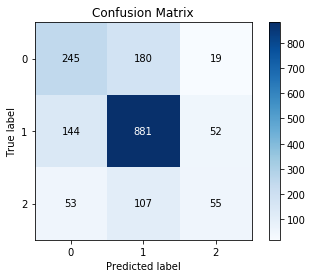

In [73]:
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

In [74]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

[[0.5518018  0.40540541 0.04279279]
 [0.13370474 0.818013   0.04828227]
 [0.24651163 0.49767442 0.25581395]]


<Figure size 720x720 with 0 Axes>

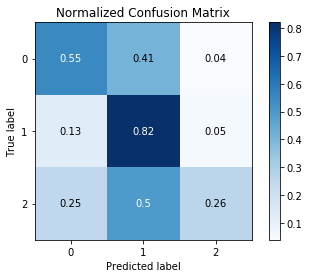

In [75]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class, normalize=True)
plt.show()

### c)- Loss and Accuracy

In [76]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.6803
Testing Loss:  0.9456


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

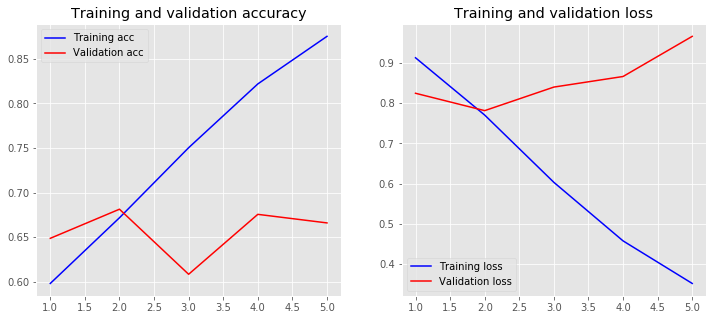

In [78]:
plot_history(history)

### d)- Checking results test set

In [79]:
y_test[:5]

5682       Neutral
6394       Neutral
2506         Risky
2165    Beneficial
1224    Beneficial
Name: sent_numeric, dtype: object

In [80]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [81]:
prediction=model.predict(X_test)
prediction[:5]

array([[0.16610548, 0.75882405, 0.07507043],
       [0.4300123 , 0.5601749 , 0.00981278],
       [0.30668792, 0.67363274, 0.01967934],
       [0.01334799, 0.9853982 , 0.00125384],
       [0.6885919 , 0.08004177, 0.2313664 ]], dtype=float32)

In [82]:
# checking with original text at index 5682
df.text.loc[2165]

'The future right there! "New Google Self-Driving Car Ditches the Steering Wheel" http://t.co/0uBbqVhASM'

In [83]:
df.loc[2165]

text            The future right there! "New Google Self-Drivi...
sent_numeric                                           Beneficial
labels                                                          1
cleaned         future right new google selfdriving car ditche...
Name: 2165, dtype: object

In [0]:
#[print(df['text'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]



**Interpret**

- We have checked 1st five sentiment from 'text' feature. So, 1st column is text<br>
- 2nd column is predicted results. These are probability values of each sentiment. 0 ,1,2 as they were encoded. 'Risky':0, 'Beneficial':1, 'Neutral':2. So, 0 is risky, 1 is beneficial and 2 is neut. Probability of risky is 0.15, beneficial is 0.819 and neut is 0.119. Clearly, this text has tendency to be beneficial having highest probability<br>
- Third column shows real values of sentiment. Sequence is same as we encoded. And we can see that actual text was of beneficial sentiment. So, our prediction is correct in this case

In [84]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, y_pred in enumerate(y_pred):
    if np.argmax(y_pred)==2:
        neg_count += 1
    elif np.argmax(y_pred)==1:
        neu_count += 1
    else:
        pos_count += 1
    
    if np.argmax(y_test_ohe[i])==2:
        real_neg += 1
    elif np.argmax(y_test_ohe[i])==1:    
        real_neu += 1
    else:
        real_pos +=1

print('Benefit predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Risk predictions:', neg_count)
print('Real Benefit values:', real_pos)
print('Real neutral values:', real_neu)
print('Real Risk values:', real_neg)

Benefit predictions: 442
Neutral predictions: 1168
Risk predictions: 126
Real Benefit values: 444
Real neutral values: 1077
Real Risk values: 215


test set has 1736.<br>
Real values are +ve as 444, neut 1077, neg 215<br>
We predicted +ve as 442, neut,1168, neg 126<br>

In [85]:
y_test.value_counts(ascending=True)

Risky          215
Beneficial     444
Neutral       1077
Name: sent_numeric, dtype: int64